# Cross Validation In Machine Learning Trading Models
Cross validation in machine learning is a technique that provides an <i><b>accurate measure of the performance</i></b> of a machine learning model. This performance will be closer to what you can expect when the model is used on a future unseen dataset. 


This notebook will help you
1. Determine if the machine learning model is good in predicting buy signal and/or sell signal
2. Demonstrate the performance of your machine learning trading model in different stress scenarios
3. Comprehensively do the cross validation in machine learning trading model


A sample machine learning <b><i>decision tree classifier model</b></i> using the <i><b>bank marketing dataset</i></b> is created to better explain how to do cross validation in machine learning model.

## Importing the required packages

In [105]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline
sns.set()

## Preparing Data
The dataset we used is realted  with direct marketing campaigns of a Portuguese banking institution and it is available [here](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing). The classification goal is to predict if the client will subscribe a <b>term deposit (variable y).</b>

In [107]:
bank_mkt = pd.read_csv('bankmkt.csv') # Read the dataset into dataframe
bank_mkt.dropna() # Remove missing value
bank_mkt.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,30,blue-collar,married,basic.9y,no,yes,no,cellular,may,fri,487,2,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
1,39,services,single,high.school,no,no,no,telephone,may,fri,346,4,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
2,25,services,married,high.school,no,yes,no,telephone,jun,wed,227,1,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
3,38,services,married,basic.9y,no,unknown,unknown,telephone,jun,fri,17,3,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
4,47,admin.,married,university.degree,no,yes,no,cellular,nov,mon,58,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no


### Creating input dataset
Here we preprocess the data to be the input dataset. The choice of features as input is completely random, you can learn more about feature selection [here](https://en.wikipedia.org/wiki/Feature_selection). 

In [108]:
# We deep copy the dataframe for parsing
bank_data = bank_mkt.copy()

In [109]:
# Drop contact since every participant has been contacted
bank_data.drop('contact', axis = 1, inplace = True)

# Dropped since they don't have intrinsic meaning 
# by knowing the last contacted date
bank_data.drop('month', axis=1, inplace=True)
bank_data.drop('day_of_week', axis=1, inplace=True)

# Map values 'yes' / 'no' to 1 / 0 
bank_data.y = bank_data.y.map({'yes': 1, 'no': 0})

In [110]:
# Convert categorical variables to dummy variables
bank_with_dummies = pd.get_dummies(
    data=bank_data, 
    columns = ['job', 'default', 'marital', 'education', 'poutcome', 'housing', 'loan'], 
    prefix = ['job', 'default', 'marital', 'education', 'poutcome', 'housing', 'loan'])
bank_with_dummies.tail()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,default_no,default_unknown,default_yes,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,poutcome_failure,poutcome_nonexistent,poutcome_success,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes
4114,30,53,1,999,0,1.4,93.918,-42.7,4.958,5228.1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1
4115,39,219,1,999,0,1.4,93.918,-42.7,4.959,5228.1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0
4116,27,64,2,999,1,-1.8,92.893,-46.2,1.354,5099.1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0
4117,58,528,1,999,0,1.4,93.444,-36.1,4.966,5228.1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0
4118,34,175,1,999,0,-0.1,93.200,-42.0,4.120,5195.8,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0


## Training the Machine Learning Model
We are going to train a decision tree classifier model here. The classifier is saved as 'clf' and the fit function is used learn the relationship between input X and output variable y using the classifier.

In [112]:
X = bank_with_dummies.drop('y', 1)
y = bank_with_dummies.y

In [113]:
clf = DecisionTreeClassifier(random_state = 5)
model = clf.fit(X, y)

Now the model is ready and let's see how to do cross validation of this model.

## Cross Validation of the Machine Learning Model
If cross validation of predictions is done on the same data from which the model learned, the performance of the model is bound to be spectacular.

In [120]:
from sklearn.metrics import accuracy_score
preds = model.predict(X) # Predicted output 
correct_Preds = accuracy_score(y, preds, normalize=False) # How many predictions are correct
print('Correct Predictions: {}'.format(correct_Preds))
print('Total Predictions: {}'.format(X.shape[0]))
print('Accuracy in Percentage: {}%'.format(accuracy_score(y, preds)*100))

Correct Predictions: 4119
Total Predictions: 4119
Accuracy in Percentage: 100.0%


### How to overcome this problem of using the same data for training and testing
<img style="height:200px" src='split.jpeg'/>
The easiest and most widely used ways is to partition the data into two parts:

1. training dataset (used to train the model)
2. testing dataset (used to test the performance of the model)

In [123]:
# Total dataset length 
dataset_length = X.shape[0]

# Training set's length
split = int(dataset_length*0.75)

In [131]:
# Splitting the dataset
X_train, X_test = X[:split], X[split:] # List comprehension
y_train, y_test = y[:split], y[split:] 

print("Spliting Manually:")
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

Spliting Manually:
(3089, 46) (1030, 46)
(3089,) (1030,)


In [132]:
# Or you can use 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

print("Using train_test_split function:")
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

Using train_test_split function:
(3089, 46) (1030, 46)
(3089,) (1030,)


### Create Model on training dataset

In [141]:
model = clf.fit(X_train, y_train)
accuracy_percentage = accuracy_score(y_test, model.predict(X_test), normalize=True)*100
print("Accuracy of the model: {:.2f}%".format(accuracy_percentage))

Accuracy of the model: 87.86%


The performance of the model on test dataset has a significant drop in accuracy from 100% to 87%. This is closer to what we would expect if the model is used in production. 

However, the cross validation in the model is done on a <b>single test dataset</b>. It could be by sheer luck that the model was able to predict with 87.86% in the test dataset. The accuracy varies if the size of test dataset. Therefore, it is needed to test on multiple unseen datasets.

### K-Fold Cross Validation Technique

This method splits the dataset into <b>K equal or close-to-equal parts</b>. Each part is called a "fold". For example, you can split your dataset into four equal parts namely P1, P2, P3 and P4. 

First model M1 is trained on P2, P3 and P4 and tested on P1. The second model M2 is trained on P1, P3 and P4 and tested on P2 and so on. The model i is trained on the union of all subsets except the ith part. The performance of the model i is tested on the ith part.

<img src="k_fold.png" style="height:400px"/>

You will end up with four accuracy values, one for each model. The mean and standard deviation of all the accuracy values can be computed and hence tell the performance of the model.

In [142]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=4, shuffle=False)
kf.split(X)

<generator object _BaseKFold.split at 0x1a260be3b8>

In [144]:
# Total dataset is divided into four different ways
for train_index, test_index in kf.split(X):
    print(train_index, test_index)

[1030 1031 1032 ... 4116 4117 4118] [   0    1    2 ... 1027 1028 1029]
[   0    1    2 ... 4116 4117 4118] [1030 1031 1032 ... 2057 2058 2059]
[   0    1    2 ... 4116 4117 4118] [2060 2061 2062 ... 3087 3088 3089]
[   0    1    2 ... 3087 3088 3089] [3090 3091 3092 ... 4116 4117 4118]


In [146]:
# The accuracy of M1, M2, M3, M4 will be stored in a list
accuracy_models = []

for train_index, test_index in kf.split(X):
    # Splitting the dataset
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model = clf.fit(X_train, y_train)
    temp_score = accuracy_score(y_test, model.predict(X_test), normalize=True)*100
    accuracy_models.append(temp_score)

accuracy_models

[89.32038834951457, 87.86407766990291, 86.60194174757282, 88.14382896015549]

### Stability of models
The accuracy of the model is 87.98% +/- 0.97%. This is more likely to be the behaviour of the model in production.

In [148]:
std = np.std(accuracy_models)
mean = np.mean(accuracy_models)
print("Mean: {:.2f}\nStd: {:.2f}".format(mean,std))

Mean: 87.98
Std: 0.97


### Selection of number of folds (value of K)
There is no definite choice for the values of K. However, the number of folds must allow the size of each validation partition to be large enough to provide a fair estimate of the model’s performance on it and shouldn’t be too small, say 2, such that we don’t have enough trained models to perform cross validation.

### Why is it better
This method gives a more stable estimate of how the model is likely to perform on average, instead of relying completely on a single model trained using a single training dataset.

### Limitation
If you train the model on a data from January 2010 to December 2018 and test on data from January 2008 to December 2009. Rightly so, the performance which we will obtain from the model will not be historically accurate.

### Confusion Matrix
This is to determine the model's accuracy in prediction each label such as "Yes" or "No. The confusion matrix will tell you the number of times the actual value was "Yes" and predicted was also "Yes" <b>(True Positive)</b>, actual value was "No" but predicted was "Yes" and so on <b>(False Positive)</b>.

In [151]:
from sklearn.metrics import confusion_matrix

# Initialize the array to zero which will store the confusion matrix
c_arrays = np.zeros((2,2)) # Shape of 2x2 matrix
c_arrays

array([[0., 0.],
       [0., 0.]])

In [152]:
# for each of the K partitions, 
# train, predict and find the confusion matrix

for train_index, test_index in kf.split(X):
    # Splitting the dataset
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model = clf.fit(X_train, y_train)
    
    # Compute the matrix and add it to c_arrays
    c = confusion_matrix(y_test, model.predict(X_test))
    c_arrays += c

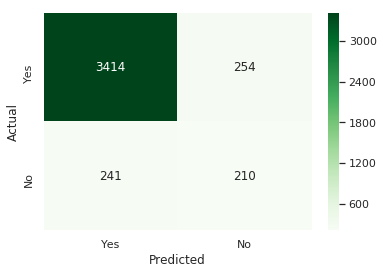

In [156]:
df = pd.DataFrame(c_arrays, index = ['Yes', 'No'], columns = ['Yes', 'No'])
sns.heatmap(df, annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

The darker green zone (3414) is the number of times when actual value was "Yes" and model also predict "No". Out of 3655 times, the model was right 3414 times. That is an accuracy of <b>93.4%</b>. We can infer that the model is better in predicting "Yes" compared to "No" in terms of subscribing term deposit.